# Salinity Analysis

**Table of Contents**
* [Working Notes](#Working-Notes)
* [Executive Summary](#Executive-Summary)
* [Graphical Analysis](#Graphical-Analysis)
* [Data Analysis](#Data-Analysis)

## Executive Summary

The goal of this notebook is to provide an easy frame work for graphical and regression analysis on the output from an OASIS model. It is configured to be used with model version 1.1. The focus of this notebook is covering behavior in Reach 2 specifically, from Rio Grande City to Los Ebanos. This is run with basedata_11_11.
- Generate a series of well-formatted graphs that can provide a cursory analysis on the output from the OASIS model.
- Run summary statistical analysis on the time series

In [1]:
# Meta functions
# Change me to `%matplotlib qt` for interactive mode
%matplotlib inline  
%load_ext autoreload
%autoreload 2

In [2]:
# Import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import gumbel_r
from sklearn.metrics import mutual_info_score

from src.lib import utils
from src.lib import stats
from src.lib import plot
from src.lib import analysis
from src.lib import constants

In [3]:
# Global variables
pd.set_option('display.max_rows', 1000)

# Set the target reach. Update this so examine your reach specifically
REACH = 2

# This is the time frame for the study, limit all results to this
START = "01/01/2021"
END = "12/31/2023"

In [4]:
# Load the datasets
OASIS_output_file = "data/all_data_12_02.csv"
df = pd.read_csv(
    OASIS_output_file, 
    header=0,  # Read the header
    skipinitialspace=True,  # OASIS outputs have leading spaces
    names=constants.FIELD_NAMES,  # Map the ideal field names to the csv, order matters so make sure the 1v file is 1-1 with the list
    parse_dates=[constants.TIMESTAMP_KEY],  # Process the date string as a datetime
    index_col=constants.TIMESTAMP_KEY  # Set the date as the index for the dataframe
)

# Take the moving average over a 5 day window to smooth out variances introduced by the time to travel value (1 day per reach)
df_5_ma = df.rolling(window=5).mean()

# Get the HUC data as well
df_huc = utils.huc2df(
    files=[f"data/Rain_Ave_Date_{REACH}N.csv", f"data/Rain_Ave_Date_{REACH}S.csv"],
    start=START,
    end=END,
)

## Graphical Analysis

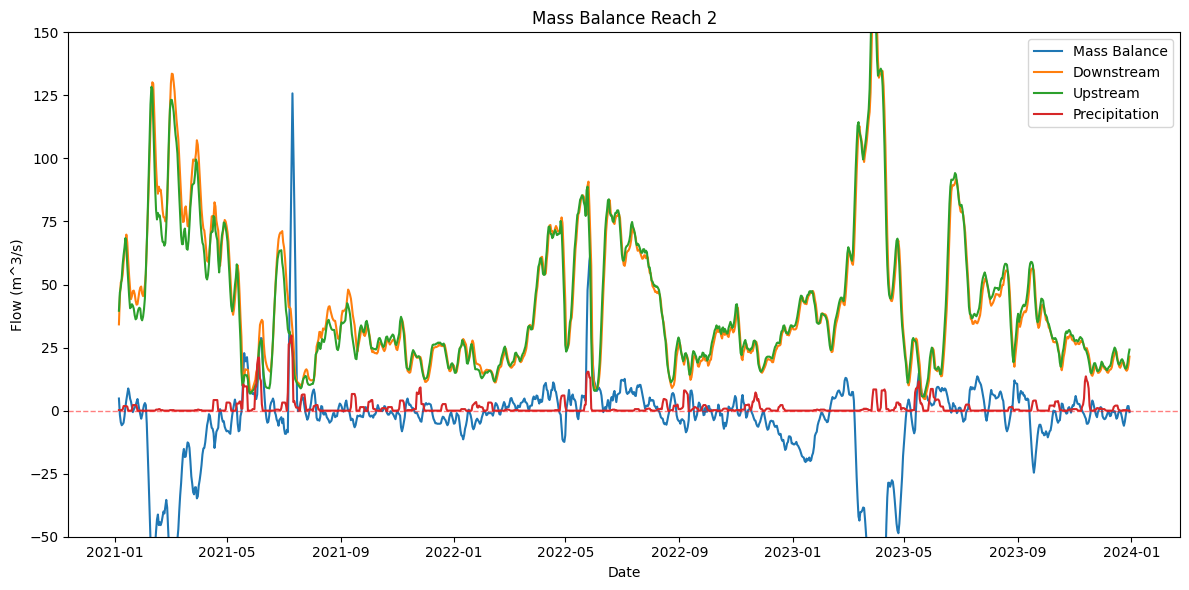

In [5]:
# Mass Balance
plt.figure(figsize=(12, 6))
ax1 = plt.gca()
ax1.set_xlabel('Date')
ax1.set_ylabel('Flow (m^3/s)')
ax1.set_ylim(-50,150)

sns.lineplot(x=constants.TIMESTAMP_KEY, y=f'MassBalanceR{REACH}', data=df_5_ma, ax=ax1, label='Mass Balance')
sns.lineplot(x=constants.TIMESTAMP_KEY, y=f'DownstreamR{REACH}', data=df_5_ma, ax=ax1, label='Downstream')
sns.lineplot(x=constants.TIMESTAMP_KEY, y=f'UpstreamR{REACH}', data=df_5_ma, ax=ax1, label='Upstream')
sns.lineplot(x=constants.TIMESTAMP_KEY, y=f'PrecipitationR{REACH}', data=df_5_ma, ax=ax1, label='Precipitation')

# Horizontal line
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1)

lines1, labels1 = ax1.get_legend_handles_labels()
ax1.legend(lines1, labels1, loc='upper left')

plt.title(f'Mass Balance Reach {REACH}')
plt.legend()
plt.tight_layout()
plt.show()

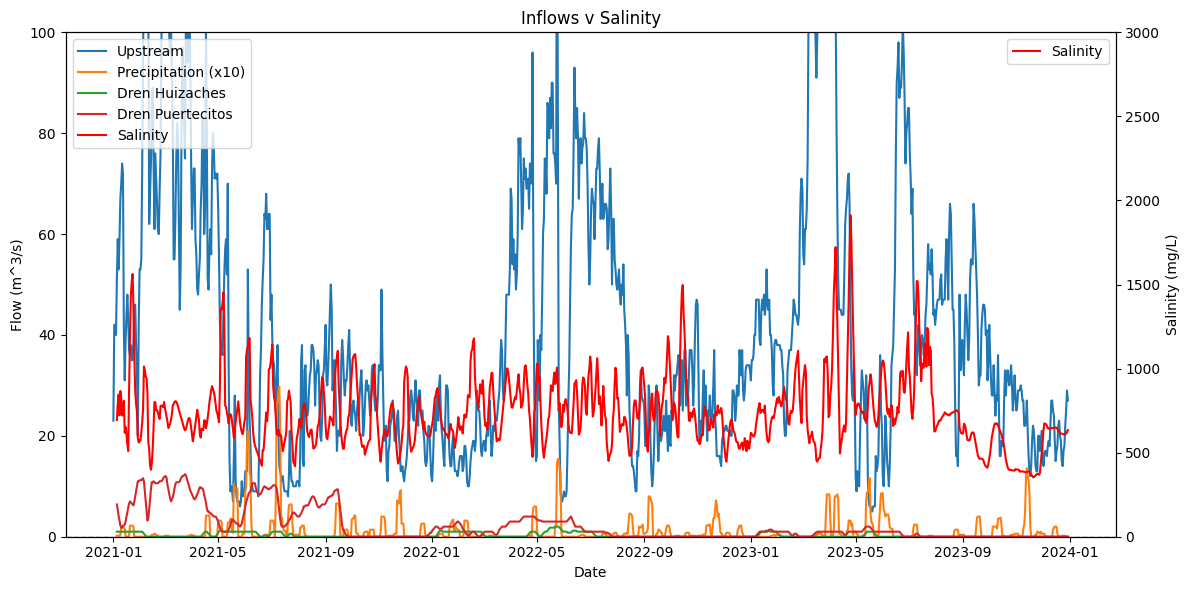

In [6]:
# Inflows Versus Salinity
plt.figure(figsize=(12, 6))
ax1 = plt.gca()
ax1.set_xlabel('Date')
ax1.set_ylabel('Flow (m^3/s)')
ax1.set_ylim(0,100)

sns.lineplot(x=constants.TIMESTAMP_KEY, y='UpstreamR2', data=df, ax=ax1, label='Upstream')
sns.lineplot(x=constants.TIMESTAMP_KEY, y='PrecipitationR2', data=df_5_ma, ax=ax1, label='Precipitation (x10)')

# Update these lines for reach-specific inflows
sns.lineplot(x=constants.TIMESTAMP_KEY, y='DrenHuizaches', data=df_5_ma, ax=ax1, label='Dren Huizaches')
sns.lineplot(x=constants.TIMESTAMP_KEY, y='DrenIndiosPuertecitos', data=df_5_ma, ax=ax1, label='Dren Puertecitos')

# Horizontal line
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1)

# Create the second y-axis
ax2 = ax1.twinx()
ax2.set_xlabel('Date')
ax2.set_ylabel('Salinity (mg/L)')
ax2.set_ylim(0,3000)

# Plot the Salinity line on the right y-axis
sns.lineplot(x=constants.TIMESTAMP_KEY, y=f'SalinityLosEbanos', data=df_5_ma, ax=ax2, color='red', label='Salinity')

# Horizontal line
ax2.axhline(y=0, color='blue', linestyle='--', alpha=0.5, linewidth=1)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title(f'Inflows v Salinity')
plt.legend()
plt.tight_layout()
plt.show()

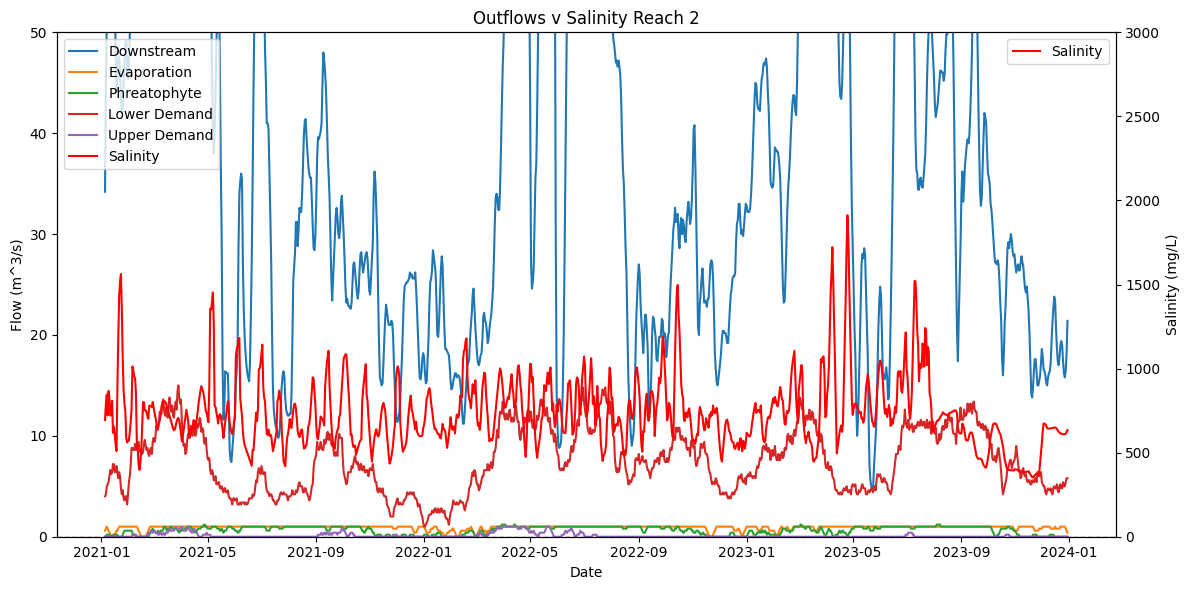

In [7]:
# Outflows Versus Salinity
plt.figure(figsize=(12, 6))
ax1 = plt.gca()
ax1.set_xlabel('Date')
ax1.set_ylabel('Flow (m^3/s)')
ax1.set_ylim(0,50)

sns.lineplot(x=constants.TIMESTAMP_KEY, y=f'DownstreamR{REACH}', data=df_5_ma, ax=ax1, label='Downstream')
sns.lineplot(x=constants.TIMESTAMP_KEY, y=f'EvaporationR{REACH}', data=df_5_ma, ax=ax1, label='Evaporation')
sns.lineplot(x=constants.TIMESTAMP_KEY, y=f'PhreatophyteR{REACH}', data=df_5_ma, ax=ax1, label='Phreatophyte')
sns.lineplot(x=constants.TIMESTAMP_KEY, y=f'LowerDemandTXR{REACH}', data=df_5_ma, ax=ax1, label='Lower Demand')
sns.lineplot(x=constants.TIMESTAMP_KEY, y=f'UpperDemandTXR{REACH}', data=df_5_ma, ax=ax1, label='Upper Demand')

# Horizontal line
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1)

# Create the second y-axis
ax2 = ax1.twinx()
ax2.set_xlabel('Date')
ax2.set_ylabel('Salinity (mg/L)')
ax2.set_ylim(0,3000)

# Plot the Salinity line on the right y-axis
sns.lineplot(x=constants.TIMESTAMP_KEY, y=f'SalinityLosEbanos', data=df_5_ma, ax=ax2, color='red', label='Salinity')

# Horizontal line
ax2.axhline(y=0, color='blue', linestyle='--', alpha=0.5, linewidth=1)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title(f'Outflows v Salinity Reach {REACH}')
plt.legend()
plt.tight_layout()
plt.show()

### Salt MB

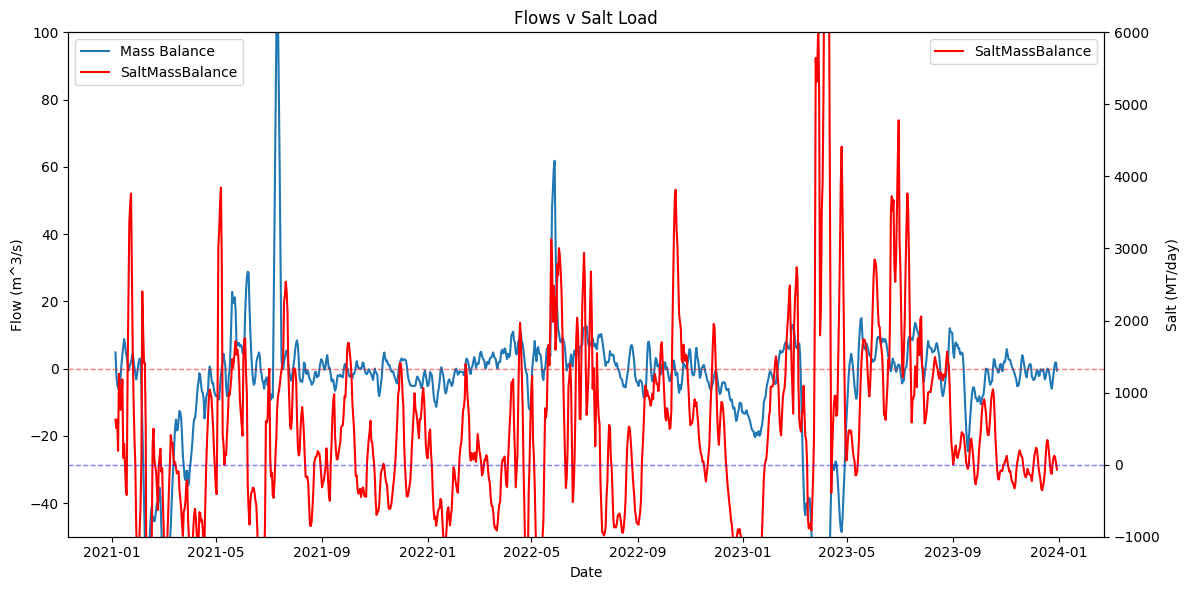

In [8]:
# Plot salt load on key flows
plt.figure(figsize=(12, 6))
ax1 = plt.gca()
ax1.set_xlabel('Date')
ax1.set_ylabel('Flow (m^3/s)')
ax1.set_ylim(-50,100)

sns.lineplot(x=constants.TIMESTAMP_KEY, y=f'MassBalanceR{REACH}', data=df_5_ma, ax=ax1, label='Mass Balance')

# Horizontal line
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1)

# Create the second y-axis
ax2 = ax1.twinx()
ax2.set_xlabel('Date')
ax2.set_ylabel('Salt (MT/day)')
ax2.set_ylim(-1000,6000)

# Plot the Salinity line on the right y-axis
sns.lineplot(x=constants.TIMESTAMP_KEY, y=f'SaltMassBalanceR{REACH}', data=df_5_ma, ax=ax2, color='red', label='SaltMassBalance')

ax2.axhline(y=0, color='blue', linestyle='--', alpha=0.5, linewidth=1)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title(f'Flows v Salt Load')
plt.legend()
plt.tight_layout()
plt.show()

## Data Analysis

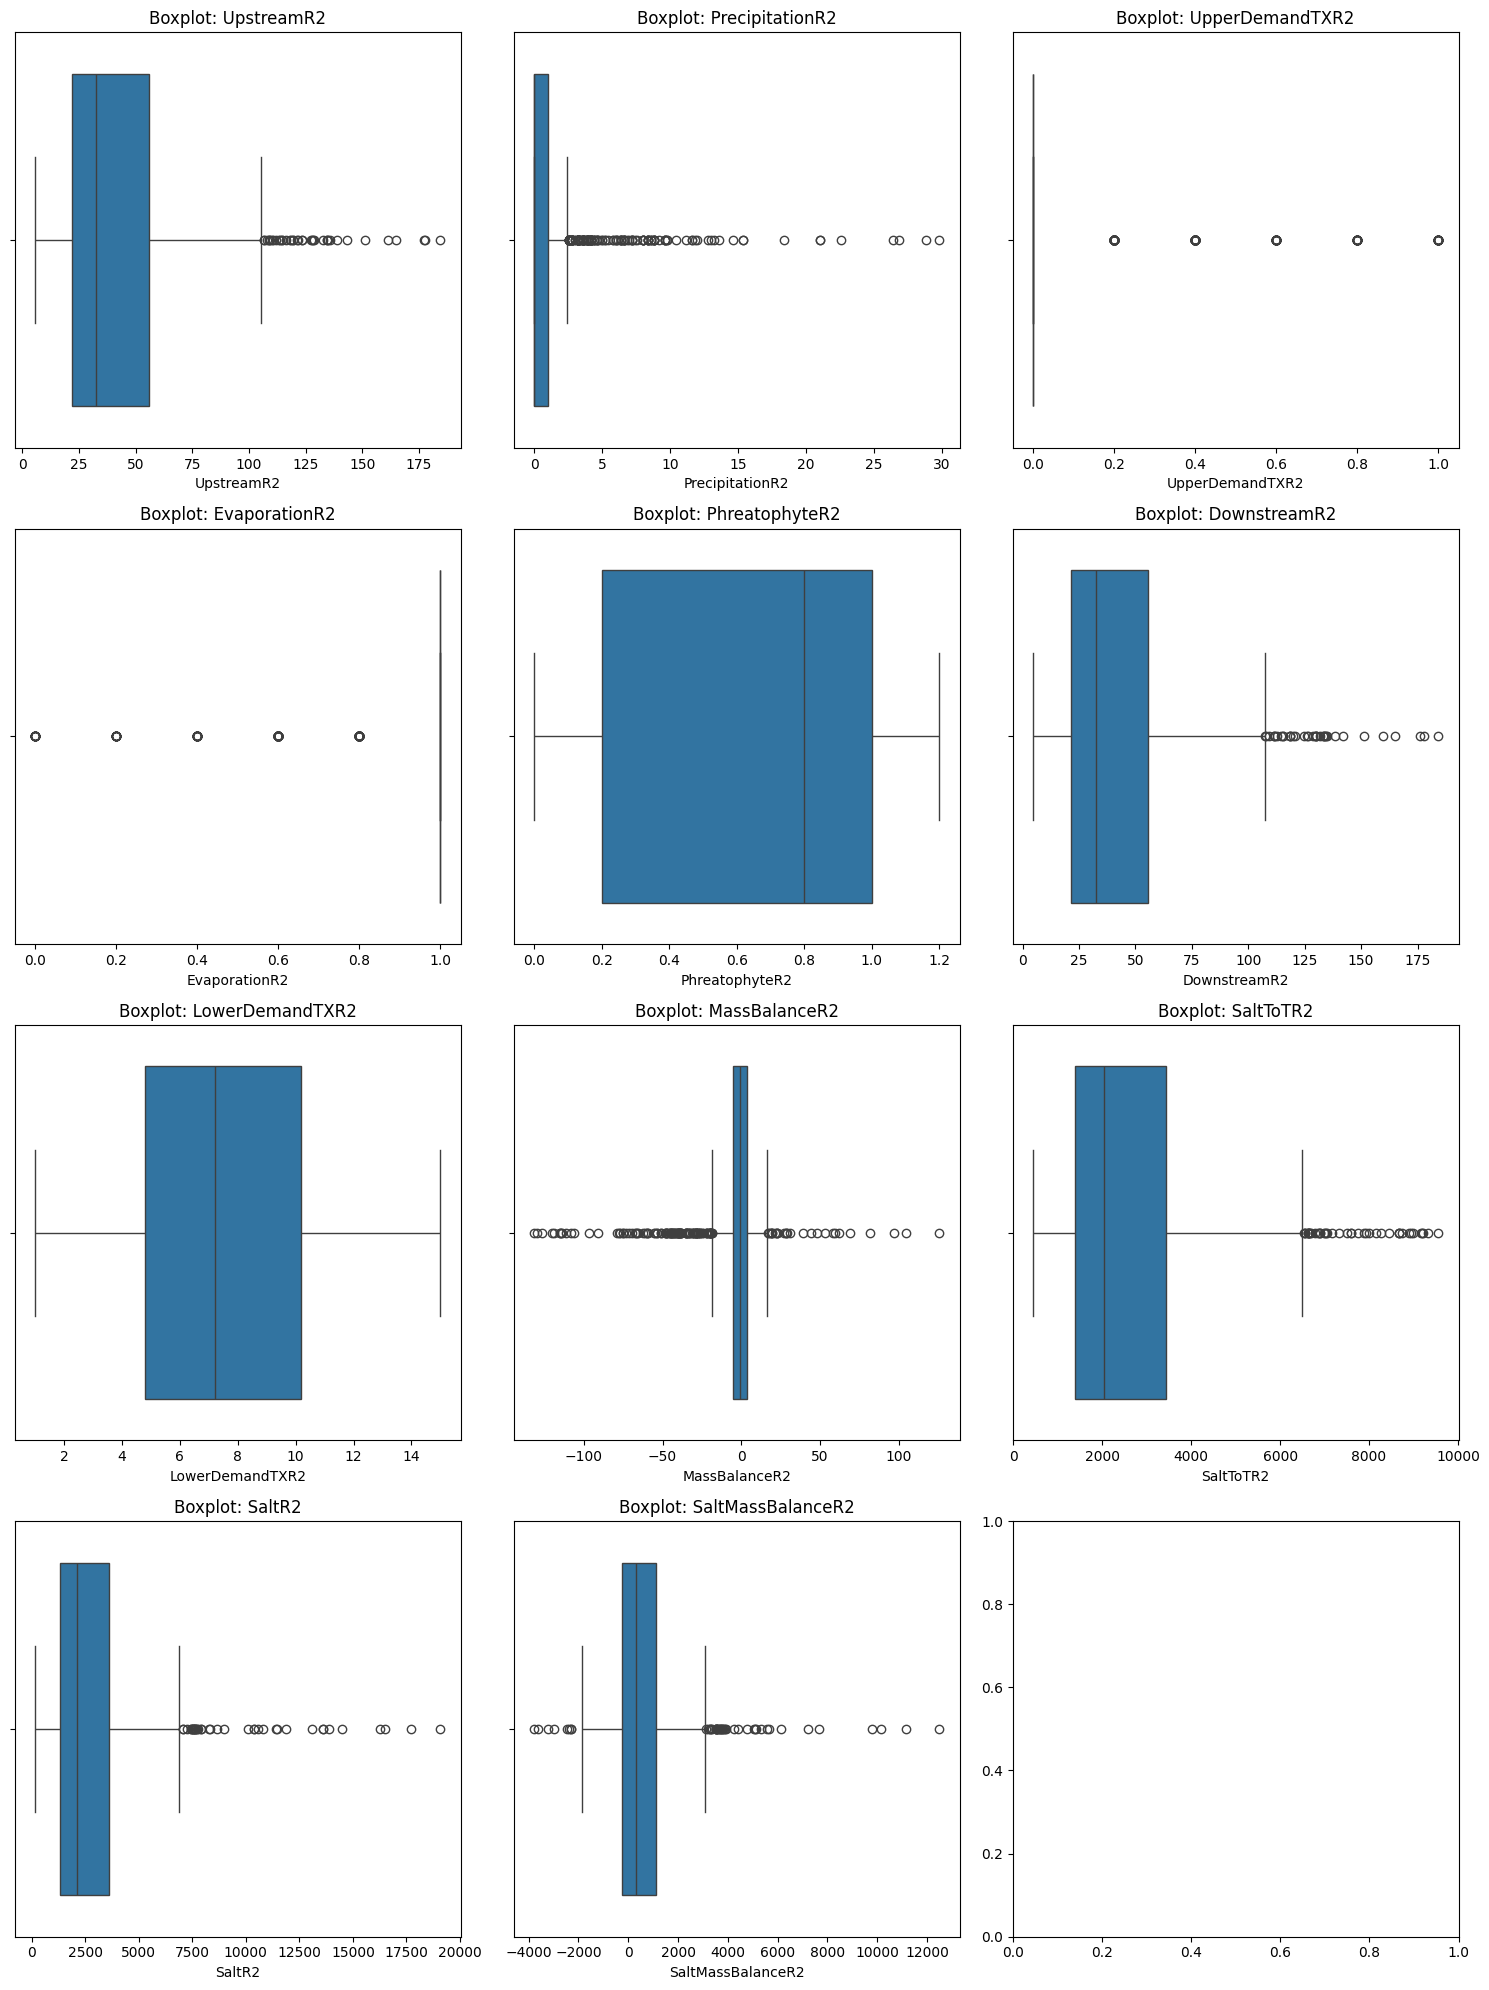

In [9]:
stats.plot_boxplot(df_5_ma, utils.get_reach_fields(reach=REACH))

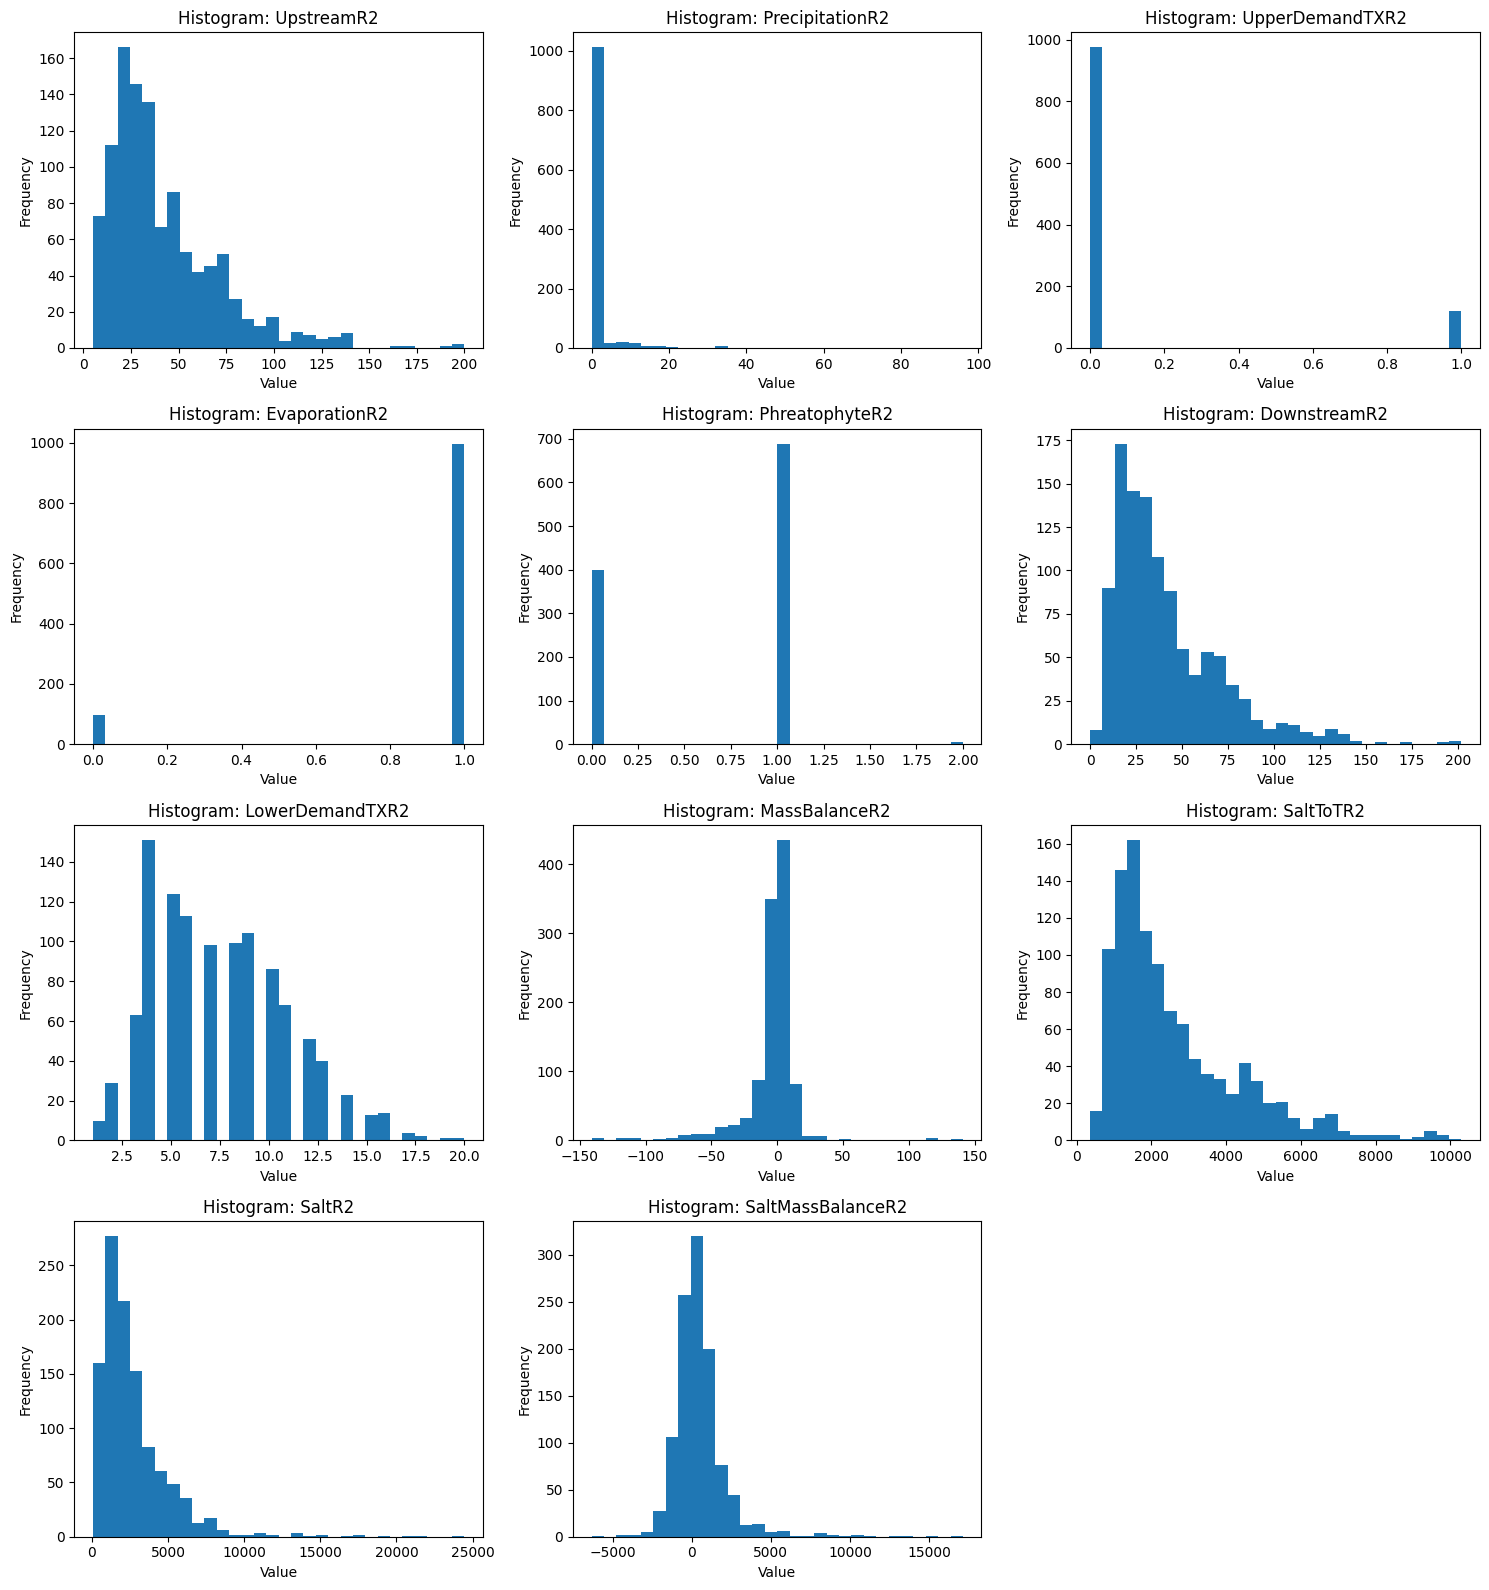

In [10]:
stats.plot_histogram(df, utils.get_reach_fields(reach=REACH))


SaltR2

ADF Statistic: -4.3806655165428845
p-value: 0.00032111331029587405
Critical Values: 
	 1%: -3.4364533503600962
	 5%: -2.864234857527328
	 10%: -2.568204837482531
True


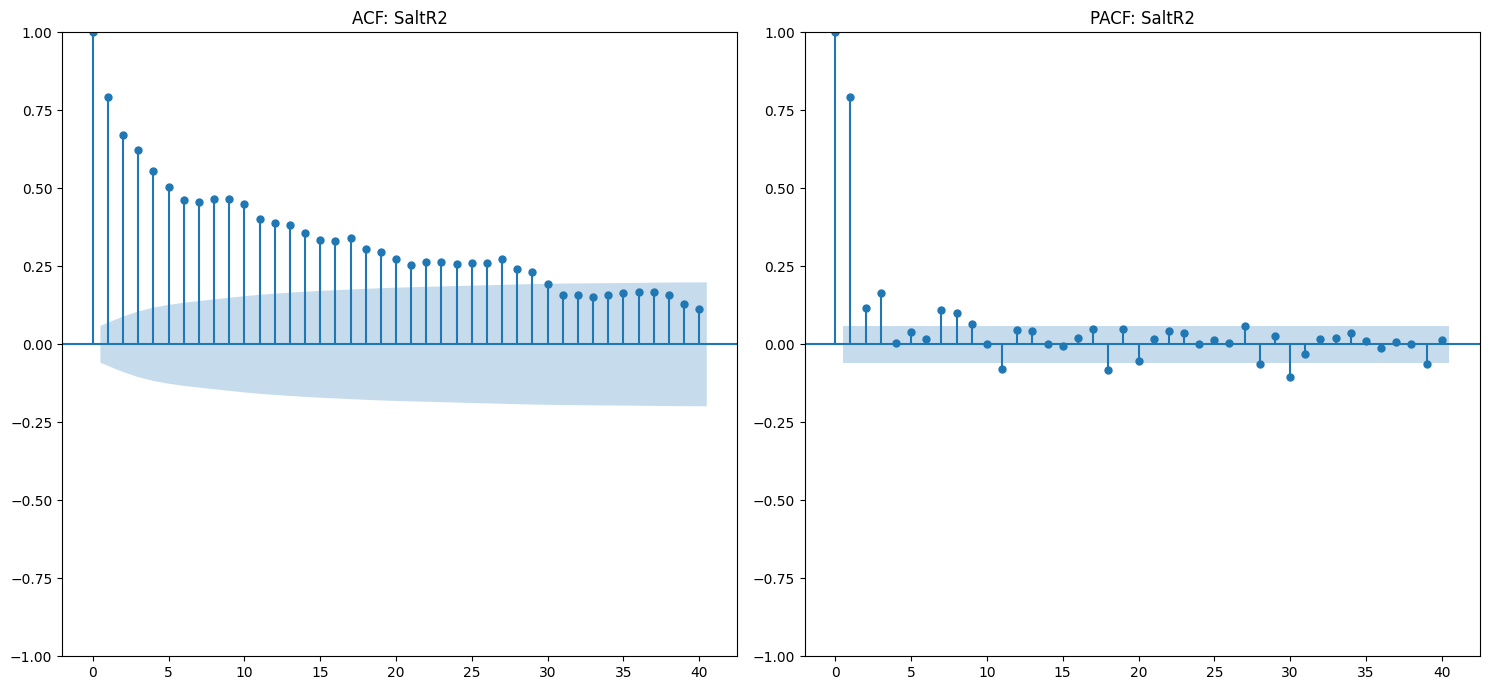

In [11]:
# Is salinity periodic?
print(stats.check_stationarity(df, f"SaltR{REACH}"))
stats.plot_acf_pacf(df, [f"SaltR{REACH}"])

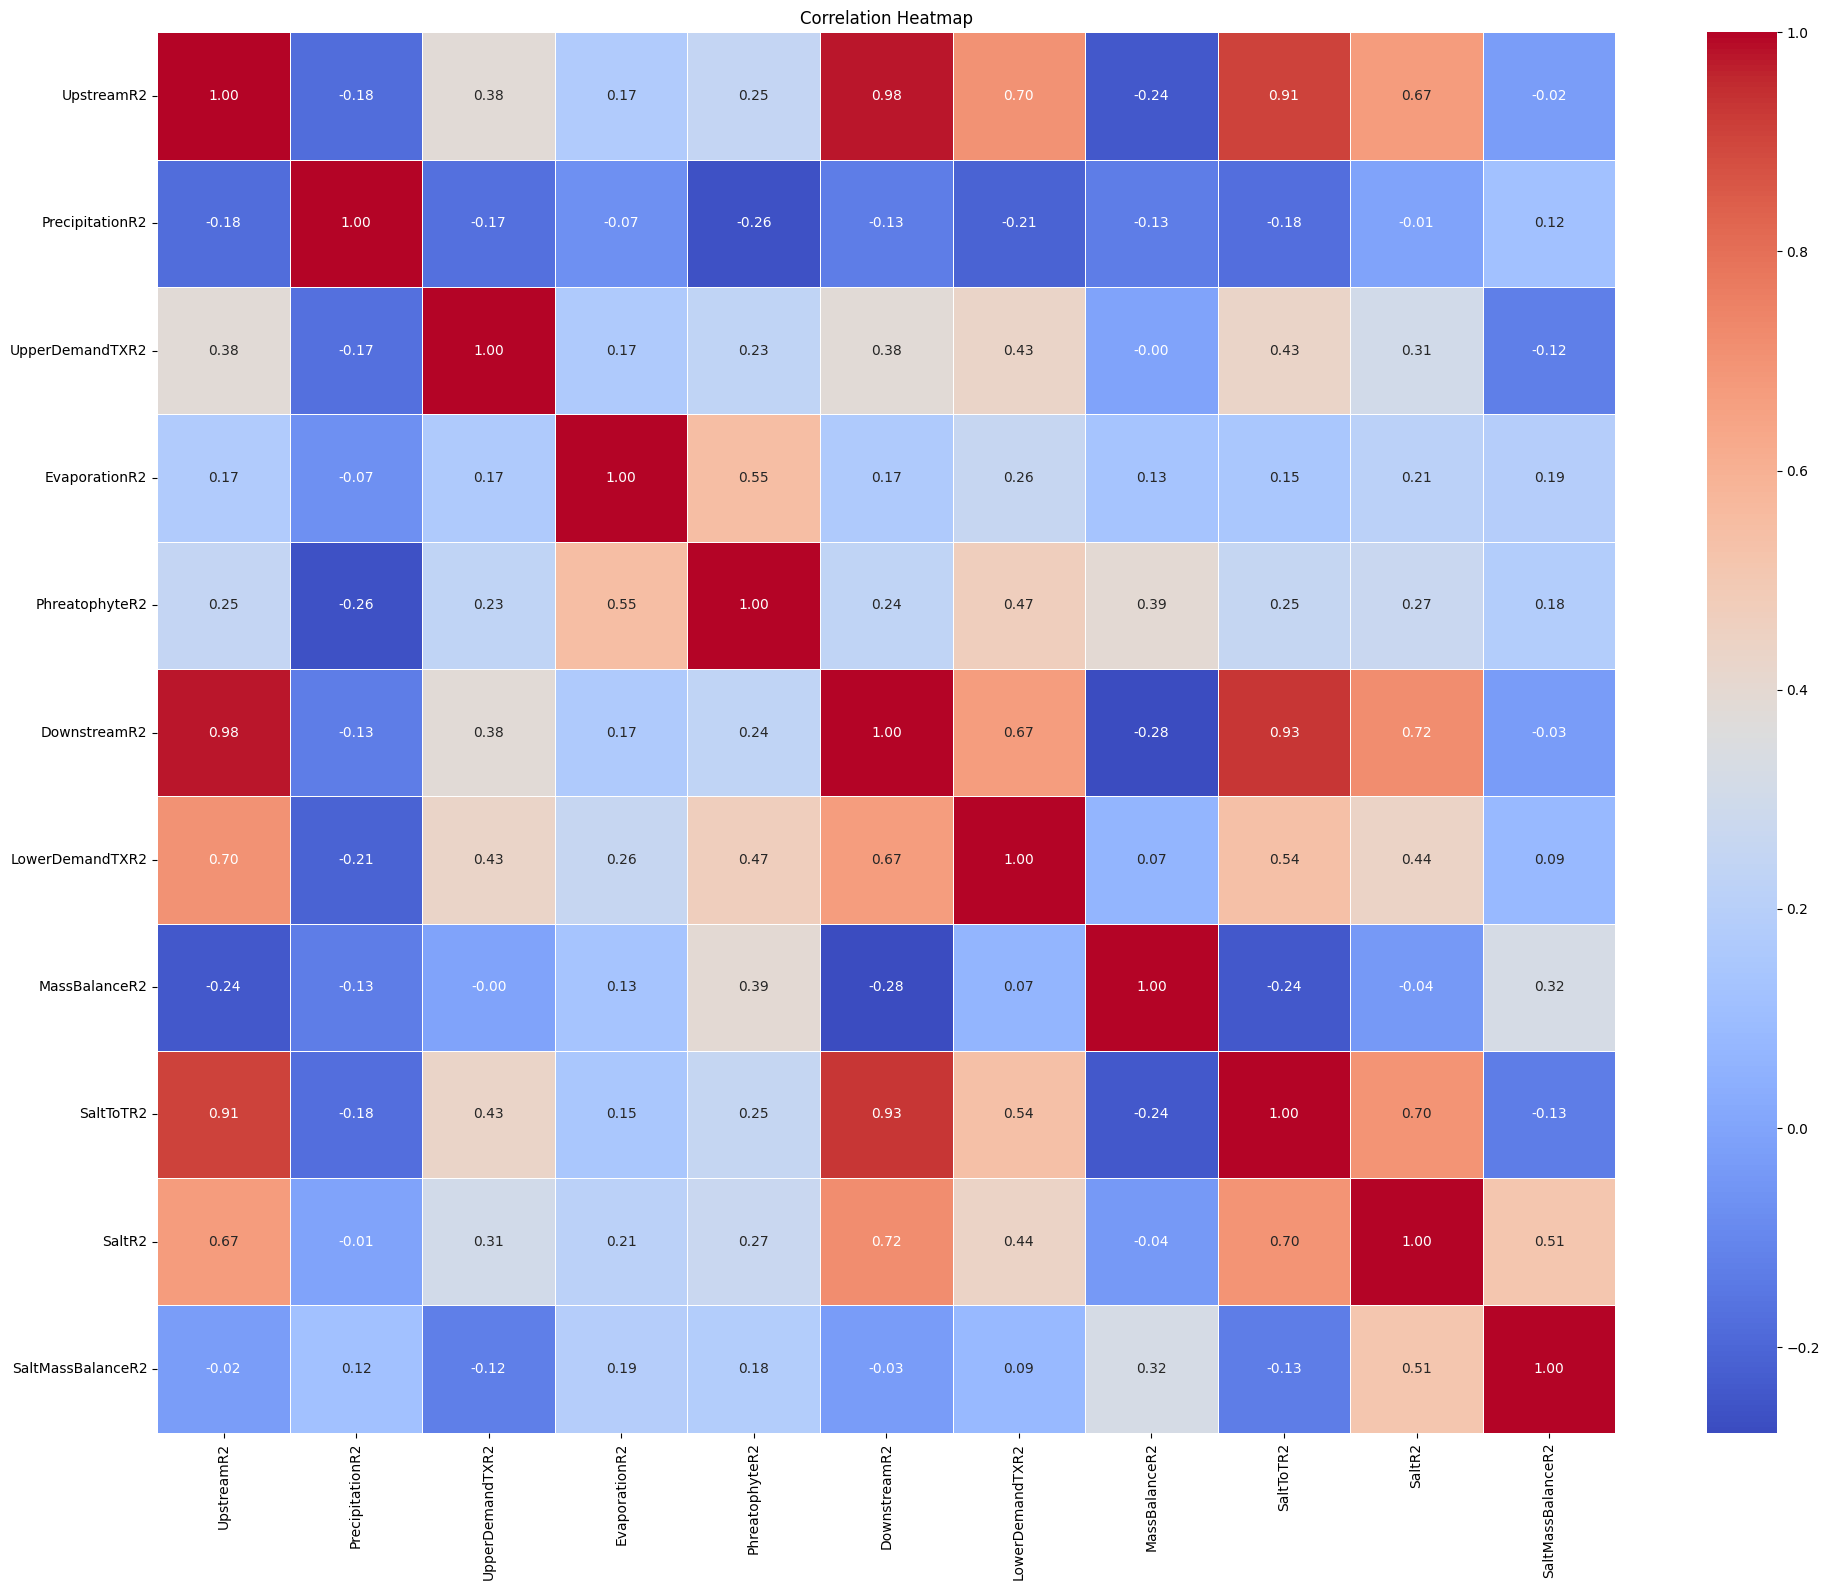

In [12]:
stats.plot_correlation_heatmap(df_5_ma[utils.get_reach_fields(reach=REACH)])

In [13]:
stats.get_stats(df, utils.get_reach_fields(reach=REACH) + ["SalinityLosEbanos"])

,mean,median,std_dev,variance
UpstreamR2,41.254113,33.0,28.514701,8.130882e+02
PrecipitationR2,1.243144,0.0,5.510808,3.036901e+01
UpperDemandTXR2,0.108775,0.0,0.311499,9.703180e-02
EvaporationR2,0.911335,1.0,0.284390,8.087781e-02
PhreatophyteR2,0.640768,1.0,0.491298,2.413740e-01
DownstreamR2,41.734004,33.0,29.294723,8.581808e+02
LowerDemandTXR2,7.492687,7.0,3.440175,1.183480e+01
MassBalanceR2,-4.197441,-1.0,22.384181,5.010516e+02
SaltToTR2,2627.804388,2050.0,1760.832347,3.100531e+06
SaltR2,2734.001828,2050.5,2493.474868,6.217417e+06


In [14]:
stats.get_dists(df[utils.get_reach_fields(reach=REACH) + ["SalinityRioGrandeCity", "SalinityLosEbanos"]])

/Users/badmin/pa325/src/lib/stats.py:249: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{'Distribution': distribution, 'Column': column,
/Users/badmin/pa325/.venv/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:6626: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/Users/badmin/pa325/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/badmin/pa325/.venv/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:8488: RuntimeWarning: overflow encountered in divide
  return (shape - 1) * np.sum(1

,Distribution,Sum of Square Error,p-value
Column,,,
DownstreamR2,uniform,0.509503,0.0000
EvaporationR2,rayleigh,0.577331,0.0000
LowerDemandTXR2,uniform,0.337487,0.0000
MassBalanceR2,exponpow,0.915492,0.0000
PhreatophyteR2,powerlaw,0.632611,0.0000
PrecipitationR2,expon,0.830896,0.0000
SalinityLosEbanos,exponpow,1.000000,0.0000
SalinityRioGrandeCity,chi2,0.827239,0.0000
SaltMassBalanceR2,exponpow,1.000000,0.0000
